# Randomized Benchmarking Tutorial

This tutorial demonstrates how to perform randomized benchmarking (RB) using `pygsti`.  While RB is a very distinct protocol from Gate Set Tomography (GST), `pygsti` includes basic support for RB because of its prevalence in the community, its simplicity, and its considerable use of GST-related concepts and data structures.  Much of the implementation draws from ideas in Wallman and Flammia's ["Randomized benchmarking with confidence"](http://iopscience.iop.org/article/10.1088/1367-2630/16/10/103032).

This tutorial will show the following, all in the context of benchmarking a single qubit:
- how to create a list of random RB sequences (experiments).  These are just a list of pyGSTi `GateString` objects.
- how to write a template data file from this list.
- how to compute RB fit parameters and average fidelity from a pyGSTi `DataSet` filled with RB sequence data.
- how to compute error bars on the various RB parameters and derived quantities.

We'll begin by importing relevant modules:

In [1]:
from __future__ import print_function #python 2 & 3 compatibility

import pygsti
from pygsti.extras import rb
from pygsti.construction import std1Q_XYI

%matplotlib inline

## Primitive gates, and how they map to Cliffords
First, let's choose a "target" gateset.  This is the set of physically-implemented, or "primitive" gates.  For this tutorial, we'll just use the standard $I$, $X(\pi/2)$, $Y(\pi/2)$ set.

In [2]:
gs_target = std1Q_XYI.gs_target
print("Primitive gates = ", gs_target.gates.keys())

Primitive gates =  [u'Gi', u'Gx', u'Gy']


To generate appropriately random RB sequences, we'll need to know how the set of all the 1-qubit Clifford gates map onto the primitive set (since RB requires sequences to be random sequences of *Cliffords*, not of primitive gates).  PyGSTi already contains the group of 1-qubit Cliffords, and defines each operator in terms of a set of seven "canonical" Clifford gates, $\{I,X(\pi/2),X(\pi),X(-\pi/2),Y(\pi/2),Y(\pi),Y(-\pi/2)\}$.

Thus, we only need to know how to express each of these canonical gates as our primitive gates; then we can compose the mappings: {all Cliffords} $\rightarrow$ {canonical Cliffords} and {canonical Cliffords} $\rightarrow$ {primitive gates} to get our desired {all Cliffords} $\rightarrow$ {primitive gates} map.

In [3]:
# get the 1Q Clifford group, used later
clifford_group = rb.std1Q.clifford_group

# get the all-Cliffords --> canonical-Cliffords map
clifford_to_canonical = rb.std1Q.clifford_to_canonical

# define the canonical-Cliffords --> primitive-gates map
canonical_to_primitive = { 'Gi':['Gi'],
            'Gxp2':['Gx'], 'Gxp':['Gx','Gx'], 'Gxmp2':['Gx','Gx','Gx'],
            'Gyp2':['Gy'], 'Gyp':['Gy','Gy'], 'Gymp2':['Gy','Gy','Gy'] }

#Compose the two maps above to get the all-Cliffords --> primitive-gates map
clifford_to_primitive = pygsti.construction.compose_alias_dicts(
                            clifford_to_canonical,canonical_to_primitive)

## Generating RB sequences
Now let's decide what random Clifford sequences to generate.  We use $m$ to denote the length of a Clifford sequence (in Clifford gates) and $K_m$ to denote the number of different random sequences of length $m$ to use.

In [4]:
m_min = 1        # minimum Clifford sequence length
m_max = 1000     # maximum Clifford sequence length
delta_m = 100    # length step size 
K_m_sched = 10   # K_m == 10 (constant) for all m

#Note: K_m_sched need not be m-independent, and can be a dictionary
# with (m,K_m) key-value pairs.  We'll demo this in a later tutorial.

Now generate the list of random RB Clifford sequences to run.  The `write_empty_rb_files` function handles this job, and does a lot. Here's what this one function call does:

- creates lists of random RB gate sequences, one list for each $m$, according to the schedule given by $m_{min}$, $m_{max}$, $\delta_m$, and $K_m$.  These sequences are expressed as strings of Clifford gate labels and translated using any of the supplied maps (in this case, the string are translated to "primitive" labels also).  These lists-of-lists are returned as a dictionary whose keys are "clifford" (always present) and "primitive" (b/c it's a key of the dict passed as `alias_maps`).
- the lists for each set of gate labels (the Cliffords and primitives in this case) is aggregated across all $m$ values (so there's just a single list of all the RB sequences) and saved to a file beginning with the given base filename.
- an empty `DataSet` is saved in text format using the RB sequences expressed in terms of Clifford gates.


In [5]:
filename_base = 'tutorial_files/rb_template'
rb_sequences = rb.write_empty_rb_files(filename_base, m_min, m_max, delta_m,
                                       clifford_group, K_m_sched,
                                       {'primitive': clifford_to_primitive},
                                       seed=0)

#Note: Because K_m_sched is a constant, we cannot use Wallman and Flammia
# error bars; if we try, the code warns us accordingly.

There is now an empty template file [tutorial_files/rb_template.txt](tutorial_files/rb_template.txt). For actual physical experiments, this file should be filled with experimental data and read in using `pygsti.io.load_dataset`.  In this tutorial, we will generate fake data instead and just use the resulting dataset object.

The files [tutorial_files/rb_template_clifford.txt](tutorial_files/rb_template_clifford.txt) and [tutorial_files/rb_template_primitive.txt](tutorial_files/rb_template_primitive.txt) are text files listing all the RB sequences, expressed in terms of Cliffords and primitives respectively.

## Generating fake data

In [6]:
#To generate a dataset, we first need to make a gateset.
#Here we assume a gate set that is perfect except for some
# small amount of depolarizing noise on each gate.
depol_strength = 1e-3
gs_experimental = std1Q_XYI.gs_target
gs_experimental = gs_experimental.depolarize(gate_noise=depol_strength)

In [7]:
#Now we choose the number of clicks per experiment and simulate our data.
#Note: the time to generate simulated data can be nontrivial, but here it
# should only take a few seconds.

all_rb_sequences = [] #construct an aggregate list of Clifford sequences
for seqs_for_single_cliff_len in rb_sequences['clifford']:
    all_rb_sequences.extend(seqs_for_single_cliff_len)
    
N=100 # number of samples
rb_data = pygsti.construction.generate_fake_data(
    gs_experimental,all_rb_sequences,N,'binomial',seed=1,
    aliasDict=clifford_to_primitive, collisionAction="keepseparate")

#Note the use of aliasDict in the line above to generate fake 
# data for *Clifford-label* sequences using a GateSet  
# containing primitive gates, and the collisionAction argument
# which is properly handles duplicate Clifford strings (the
# default behavior aggregates duplicate strings, but this is
# *not* what we want for RB, which relies on *independently*
# chosen strings without regard for duplicates).

## Running the RB analysis
Now that we have data, it's time to perform the RB analysis.  The 
function `do_randomized_benchmarking` returns an `RBResults` object which holds all the relevant (input and output) RB quantities.  This object can (and will!) be used to generate error bars on the computed RB quanties.

Some useful arguments are:
- success_spamlabel : the spam label corresponding to the *expected* outcome when preparing and immediately measuring.
- dim : the Hilbert space dimension.  This defaults to 2 (the 1-qubit case) and so can usually be left out.
- pre_avg :  Are we, prior to fitting to the RB decay curve, going to "pre-average" the data?  That is, are we using a single survival probability per sequence length or not?  For now we recommend keeping this set to True (the default) for consitency with the literature.
- clifford_to_primitive : specifying this map causes per-primitive values to be computed in addition to the usual per-Clifford values (of the average fidelity, for instance) NOTE, however, that RB IS NOT GUARANTEED TO GIVE RELIABLE A PRIMITIVE ANALYSIS (and in general will not!).

In [8]:
rb_results = rb.do_randomized_benchmarking(rb_data, all_rb_sequences,
                                           success_spamlabel='minus', dim=2, pre_avg=True,
                                           clifford_to_primitive = clifford_to_primitive)

## Examining the output

Okay, so we've done RB!  Now let's examine how we can use the returned `RBResults` object to visualize and inspect the results.  First let's plot the decay curves.

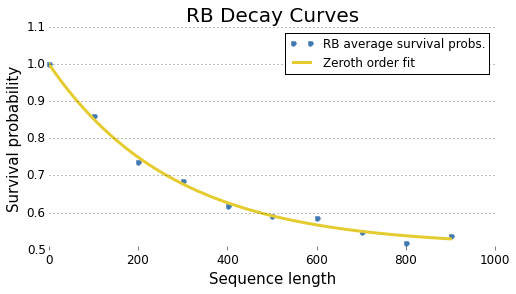

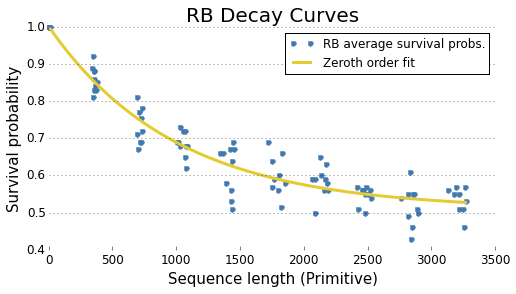

In [9]:
#Note: because we pre-averaged, each data blue data point is simply an 
# average of multiple success rates. However, for the primitives plot,
# many sequences have a unique primitive sequence length, so this effect
# is not nearly as pronounced.
rb_results.plot('clifford')
rb_results.plot('primitive')

Let's look at the RB fit results.  The parameters are defined as follows,
following the Wallman and Flammia article cited above.
- `A`,`B`,`f` are fit parameters to the function $F(m) = A+B\,f^m$, where $F(m)$ is the survival probability for sequences of length $m$.
- `F_avg` $= ((d-1)\,f+1)/d$, where for 1 qubit, $d=2$.  $F_{avg}$ is the average (Clifford or primitive) gate fidelity.
- `r` $= 1-F_{avg}$.  For Cliffords, $r$ is the "RB number."

In [10]:
rb_results.print_clifford()
print
rb_results.print_primitive()

clifford results 
  - Using zeroth order fitting function: A + B*f^m  
A = 0.509876520858
B = 0.490123479142
f = 0.996421673104
F_avg = 0.998210836552
r = 0.0017891634481

primitive results 
  - Using zeroth order fitting function: A + B*f^m  
A = 0.509072311819
B = 0.490927688181
f = 0.998995358684
F_avg = 0.999497679342
r = 0.000502320657821



## Determining error rate
Because we generated our data from a known Markovian gate set, we can analytically compute the Clifford RB error rate r.

In [11]:
#First we make map our experimental gate set of primitive operations
#into a dictionary of Cliffords:
gs_cliff_experimental = pygsti.construction.build_alias_gateset(
                                gs_experimental,clifford_to_primitive)

#Then we directly compute the average twirled Clifford error rate:
analytic_rb_error_rate = rb.analytic_rb_clifford_gateset_error_rate(
                                            gs_cliff_experimental,
                                            rb.std1Q.gs_clifford_target,
                                            rb.std1Q.clifford_group)

print("Analytic RB error rate:", analytic_rb_error_rate)
print("Experimental RB error rate:", rb_results.dicts['clifford']['r'])

Analytic RB error rate: 0.00176791958146
Experimental RB error rate: 0.0017891634481


## Error Bars
Lastly, let's put some error bars on the estimates. Because we used a constant K_m_sched, we can't compute analytic error bars using the Wallman and Flammia method. We can instead, however, compute bootstrapped error bars. Error bars here are 1-sigma confidence intervals.

In [12]:
rb_results.compute_bootstrap_error_bars(('clifford','primitive'),seed=0)

Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-parametric dataset.
Generating non-param

Now that we've generated (bootstrapped) error bars, we can print them using the same print methods as before:

In [13]:
rb_results.print_clifford()
print
rb_results.print_primitive()

clifford results 
  - Using zeroth order fitting function: A + B*f^m  
  - with boostrapped-derived error bars (1 sigma):
A = 0.509876520858 +/- 0.0126527735293
B = 0.490123479142 +/- 0.0121282375704
f = 0.996421673104 +/- 0.000255820930647
F_avg = 0.998210836552 +/- 0.000127910465323
r = 0.0017891634481 +/- 0.000127910465323

primitive results 
  - Using zeroth order fitting function: A + B*f^m  
  - with boostrapped-derived error bars (1 sigma):
A = 0.509072311819 +/- 0.0137958930821
B = 0.490927688181 +/- 0.0125892771585
f = 0.998995358684 +/- 8.03792583261e-05
F_avg = 0.999497679342 +/- 4.01896291631e-05
r = 0.000502320657821 +/- 4.01896291631e-05



In [14]:
#We can also manually extract the error bars now; for example:
print(rb_results.dicts['clifford']['r_error_BS'])

0.000127910465323


## First order fitting model

As well as fitting to the standard "zeroth order" RB decay model, $F(m) = A+B\,f^m$, the data is also fit to the "first order" decay model, as defined by Magesan et al ["Scalable and Robust Benchmarking of Quantum Processes"](http://journals.aps.org/prl/abstract/10.1103/PhysRevLett.106.180504). This is the fit model $F(m) = A_1 + B_1 f^m + C_1(D_1 - f^2)f^{m-2}$. The average gate fidilety and the "RB number" are then calculated from $f$ as with the "zeroth order" decay model.

The fit parameters can be extracted by specifying the optional parameter order='zeroth','first' or 'all' in the print and plot commands introduced above. E.g: 



In [15]:
rb_results.print_clifford(order='all')

clifford results 
  - Using zeroth order fitting function: A + B*f^m  
  - with boostrapped-derived error bars (1 sigma):
A = 0.509876520858 +/- 0.0126527735293
B = 0.490123479142 +/- 0.0121282375704
f = 0.996421673104 +/- 0.000255820930647
F_avg = 0.998210836552 +/- 0.000127910465323
r = 0.0017891634481 +/- 0.000127910465323

clifford results 
   - Using first order fitting function: A1 + (B1+C1m)*f^m 
   - with boostrapped-derived error bars (1 sigma):
A1 = 0.509876520858 +/- 0.0126690114415
B1 = 0.490123479142 +/- 0.0121397360501
C1 = -3.39065966103e-15 +/- 3.70394287178e-08
f1 = 0.996421673104 +/- 0.000256188540469
F_avg1 = 0.998210836552 +/- 0.000128094270235
r1 = 0.0017891634481 +/- 0.000128094270235



The first order fitting model is claimed to be preferable when there is small but non-negligable gate-dependency in the error map associated with each Clifford.

`gdep` = $D_1 - f^2$ and this is claimed by Magesan et al to be a measure of the gate-dependence of the noise, in that significantly non-zero values are associated with gate-dependence. Note that the $C_1$ value is meaningless in isolation (hence non-zero values are not important on their own) as there are only four indepedent parameters in the first order fit (rather than five) -- the decay parameter and constant factors in front of: a constant term, pure exponential decay and an $m f^m$ term.

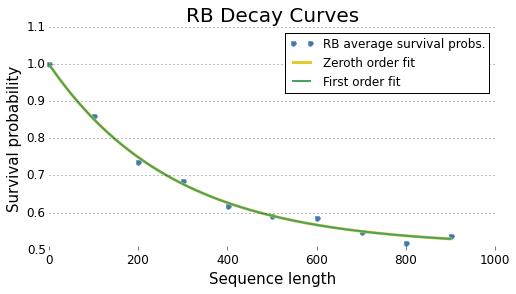

In [16]:
rb_results.plot('clifford',order='all')